In [8]:
%tensorflow_version 1.x

In [9]:
%matplotlib inline
import tensorflow as tf 
import matplotlib.pyplot as plt
import numpy as np

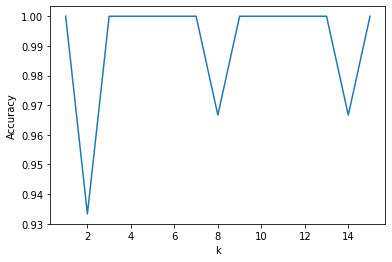

In [19]:
tf.reset_default_graph()

# KNN klasa.
class KNN:
  
  def __init__(self, nb_features, nb_classes, data, k, weighted = False):
    self.nb_features = nb_features
    self.nb_classes = nb_classes
    self.data = data
    self.k = k
    self.weight = weighted
    
    # Gradimo model, X je matrica podataka a Q je vektor koji predstavlja upit.
    self.X = tf.placeholder(shape=(None, nb_features), dtype=tf.float32)
    self.Y = tf.placeholder(shape=(None), dtype=tf.int32)
    self.Q = tf.placeholder(shape=(nb_features), dtype=tf.float32)
    
    # Racunamo kvadriranu euklidsku udaljenost i uzimamo minimalnih k.
    dists = tf.sqrt(tf.reduce_sum(tf.square(tf.subtract(self.X, self.Q)), 
                                  axis=1))
    _, idxs = tf.nn.top_k(-dists, self.k)  
    
    self.classes = tf.gather(self.Y, idxs)
    self.dists = tf.gather(dists, idxs)
    
    self.w = tf.fill([k], 1/k)
    
    # Svaki red mnozimo svojim glasom i sabiramo glasove po kolonama.
    w_col = tf.reshape(self.w, (k, 1))
    self.classes_one_hot = tf.one_hot(self.classes, nb_classes)
    self.scores = tf.reduce_sum(w_col * self.classes_one_hot, axis=0)
    
    # Klasa sa najvise glasova je hipoteza.
    self.hyp = tf.argmax(self.scores)
  
  # Ako imamo odgovore za upit racunamo i accuracy.
  def predict(self, query_data):
    
    with tf.Session() as sess:
      sess.run(tf.global_variables_initializer())
     
      nb_queries = query_data['x'].shape[0]
      
      matches = 0
      for i in range(nb_queries):
        hyp_val = sess.run(self.hyp, feed_dict = {self.X: self.data['x'], 
                                                  self.Y: self.data['y'], 
                                                 self.Q: query_data['x'][i]})
        if query_data['y'] is not None:
          actual = query_data['y'][i]
          match = (hyp_val == actual)
          if match:
            matches += 1
          #if not match:
            #print("Predicted: {}| Actual: {}".format(hyp_val, actual))
          #if i % 10 == 0:
            #print('Test example: {}/{}| Predicted: {}| Actual: {}| Match: {}'
                 #.format(i+1, nb_queries, hyp_val, actual, match))
      
      accuracy = matches / nb_queries
      #print('{} matches out of {} examples'.format(matches, nb_queries))
      return accuracy

# Učitavanje i obrada podataka.
filename = 'iris.csv'
all_data = np.loadtxt(filename, delimiter=',', skiprows=1, usecols=(0, 1, 2, 3))
classes_str = np.loadtxt(filename, delimiter=',', dtype=np.str, skiprows=1, usecols=(4))

def class_string_to_int(class_string):
  if class_string == 'Iris-setosa':
    return 0
  elif class_string == 'Iris-versicolor':
    return 1
  elif class_string == 'Iris-virginica':
    return 2

classes_int = list(map(class_string_to_int, classes_str))
classes_int = np.array(classes_int)

data = dict()
data['x'] = all_data[:, :4]
data['y'] = classes_int

# Nasumično mešanje.
nb_samples = data['x'].shape[0]
indices = np.random.permutation(nb_samples)
data['x'] = data['x'][indices]
data['y'] = data['y'][indices]

# Deljenje na trening deo i test deo.
train_ratio = 0.8

nb_train = int(train_ratio * nb_samples)
data_train = dict()
data_train['x'] = data['x'][:nb_train]
data_train['y'] = data['y'][:nb_train]

nb_test = nb_samples - nb_train
data_test = dict()
data_test['x'] = data['x'][nb_train:]
data_test['y'] = data['y'][nb_train:]

nb_features = 4
nb_classes = 3
k = 3

train_data = {'x': data_train['x'], 'y': data_train['y']}
test_data = {'x': data_test['x'], 'y': data_test['y']}

acc = []
for k in range(1,16):
  knn = KNN(nb_features, nb_classes, train_data, k, weighted = False)
  accuracy = knn.predict(test_data)
  #print('Test set accuracy: ', accuracy)
  #print('\n')
  acc.append(accuracy)

k = np.arange(1,16,1)
ll = plt.plot(k,acc)
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.show()

# U ovom zadatku dosta je veci accuracy nego u prethodnom jer ukljucujemo svaki feature iz originalnog fajla,
# a u prethodnom ukljucujemo samo prva dva. 
# Accuracy je u vecini slucajeva veci od 0.9
# Razlika accuracy u odnosu na izbor k je dosta manja u zadatku pod c nego u zadatku pod b.

